In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telecom-dataset/telco.csv


# Preparation for modelling

In [2]:
data = pd.read_csv('/kaggle/input/telecom-dataset/telco.csv')

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043 non-null   object 


In [3]:
data.head()
data.describe()

,SeniorCitizen,tenure,MonthlyCharges
count,7043.000000,7043.000000,7043.000000
mean,0.162147,32.371149,64.761692
std,0.368612,24.559481,30.090047
min,0.000000,0.000000,18.250000
25%,0.000000,9.000000,35.500000
50%,0.000000,29.000000,70.350000
75%,0.000000,55.000000,89.850000
max,1.000000,72.000000,118.750000


In [4]:
custid = ['customerID']
target = ['Churn']

categorical = data.nunique()[data.nunique()< 10].keys().tolist()
categorical.remove(target[0])
numerical = [col for col in data.columns if col not in custid + target + categorical]

print(categorical)
print(numerical)


['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']
['tenure', 'MonthlyCharges', 'TotalCharges']


In [5]:
data.dtypes


data['TotalCharges'] = data['TotalCharges'].replace(r'\s+', np.nan, regex=True)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'])

In [6]:
data.isnull().sum(axis = 0)

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

In [7]:
data = data.fillna(value=0)

data = pd.get_dummies(data = data, columns = categorical, drop_first=True)
data.head()

,customerID,tenure,MonthlyCharges,TotalCharges,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,...,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
0,7590-VHVEG,1,29.85,29.85,No,0,0,1,0,0,...,0,0,0,0,0,0,1,0,1,0
1,5575-GNVDE,34,56.95,1889.50,No,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,1
2,3668-QPYBK,2,53.85,108.15,Yes,1,0,0,0,1,...,0,0,0,0,0,0,1,0,0,1
3,7795-CFOCW,45,42.30,1840.75,No,1,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,9237-HQITU,2,70.70,151.65,Yes,0,0,0,0,1,...,0,0,0,0,0,0,1,0,1,0


In [8]:


churners_number = len(data[data['Churn'] == 1])
print("Number of churners", churners_number)

churners = (data[data['Churn'] == 1])

non_churners = data[data['Churn'] == 0].sample(n=churners_number)
print("Number of non-churners", len(non_churners))
data2 = churners.append(non_churners)

Number of churners 0
Number of non-churners 0


# Encode categorical and scale numerical variables

In [9]:
# Import StandardScaler library
from sklearn.preprocessing import StandardScaler

# Perform one-hot encoding to categorical variables 
#


# Initialize StandardScaler instance
scaler = StandardScaler()

# Fit and transform the scaler on numerical columns
scaled_numerical = scaler.fit_transform(data[numerical])

# Build a DataFrame from scaled_numerical
scaled_numerical = pd.DataFrame(scaled_numerical, columns=numerical)

# Drop non-scaled numerical columns 
data = data.drop(columns=numerical, axis=1)

# Merge the non-numerical with the scaled numerical data
data = data.merge(right=scaled_numerical,how='left',left_index=True,right_index=True)

data.head()

,customerID,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,7590-VHVEG,No,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,-1.277445,-1.160323,-0.992611
1,5575-GNVDE,No,1,0,0,0,1,0,0,0,...,0,1,0,0,0,0,1,0.066327,-0.259629,-0.172165
2,3668-QPYBK,Yes,1,0,0,0,1,0,0,0,...,0,0,0,1,0,0,1,-1.236724,-0.362660,-0.958066
3,7795-CFOCW,No,1,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0.514251,-0.746535,-0.193672
4,9237-HQITU,Yes,0,0,0,0,1,0,0,1,...,0,0,0,1,0,1,0,-1.236724,0.197365,-0.938874


In [10]:
try:
    customer_id = data['customerID'] # Store this as customer_id variable
    del data['customerID'] # Don't need in ML DF
except:
    print("already removed customerID")


data.head()

,Churn,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,No,0,0,1,0,0,1,0,0,0,...,0,0,0,1,0,1,0,-1.277445,-1.160323,-0.992611
1,No,1,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,1,0.066327,-0.259629,-0.172165
2,Yes,1,0,0,0,1,0,0,0,0,...,0,0,0,1,0,0,1,-1.236724,-0.362660,-0.958066
3,No,1,0,0,0,0,1,0,0,0,...,0,1,0,0,0,0,0,0.514251,-0.746535,-0.193672
4,Yes,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,1,0,-1.236724,0.197365,-0.938874


In [11]:
data['Churn'].replace(to_replace='Yes', value=1, inplace=True)
data['Churn'].replace(to_replace='No',  value=0, inplace=True)

In [12]:
    
try:
    label = data['Churn'] # Remove the label before training the model
    del data['Churn']
except:
    print("label already removed.")
    

In [13]:
data.head()

,gender_Male,SeniorCitizen_1,Partner_Yes,Dependents_Yes,PhoneService_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,...,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,0,0,0,...,0,0,0,1,0,1,0,-1.277445,-1.160323,-0.992611
1,1,0,0,0,1,0,0,0,0,0,...,0,1,0,0,0,0,1,0.066327,-0.259629,-0.172165
2,1,0,0,0,1,0,0,0,0,0,...,0,0,0,1,0,0,1,-1.236724,-0.362660,-0.958066
3,1,0,0,0,0,1,0,0,0,0,...,0,1,0,0,0,0,0,0.514251,-0.746535,-0.193672
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,0,1,0,-1.236724,0.197365,-0.938874


# Segregate to Train and Test set

In [14]:
from sklearn.model_selection import train_test_split

# Split X and Y into training and testing datasets
train_X, test_X, train_Y, test_Y = train_test_split(data, label, test_size=0.25)

# Ensure training dataset has only 75% of original X data
print(train_X.shape[0] / data.shape[0])

# Ensure testing dataset has only 25% of original X data
print(test_X.shape[0] / data.shape[0])

0.7499645037626012
0.25003549623739885


# Regression using Decision Tree Classifier

In [15]:
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn import tree

# Initialize the model with max_depth set at 5
mytree = tree.DecisionTreeClassifier(max_depth = 5)

# Fit the model on the training data
treemodel = mytree.fit(train_X, train_Y)

# Predict values on the testing data
pred_Y = treemodel.predict(test_X)

# Measure model performance on testing data
accuracy_score(test_Y, pred_Y)

0.7938671209540034

In [16]:
# Initialize the Decision Tree
clf = tree.DecisionTreeClassifier(max_depth = 7, 
                                  criterion = 'gini', 
                                  splitter  = 'best')

# Fit the model to the training data
clf = clf.fit(train_X, train_Y)

# Predict the values on test dataset
pred_Y = clf.predict(test_X)

# Print accuracy values
print("Training accuracy: ", np.round(clf.score(train_X, train_Y), 3)) 
print("Test accuracy: ", np.round(accuracy_score(test_Y, pred_Y), 3))

Training accuracy:  0.823
Test accuracy:  0.79


# Logistic Regression for Churn prediction. 

In [17]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit(train_X, train_Y)

from sklearn.metrics import accuracy_score
pred_train_Y = logreg.predict(train_X)
pred_test_Y = logreg.predict(test_X)
train_accuracy = accuracy_score(train_Y, pred_train_Y)
test_accuracy = accuracy_score(test_Y, pred_test_Y)
print('Training accuracy:', round(train_accuracy,4))
print('Test accuracy:', round(test_accuracy, 4))

Training accuracy: 0.8014
Test accuracy: 0.8189


In [18]:
from sklearn.metrics import precision_score, recall_score
train_precision = round(precision_score(train_Y, pred_train_Y), 4)
test_precision = round(precision_score(test_Y, pred_test_Y), 4)
train_recall = round(recall_score(train_Y, pred_train_Y), 4)
test_recall = round(recall_score(test_Y, pred_test_Y), 4)
print('Training precision: {}, Training recall: {}'.format(train_precision, train_recall))
print('Test precision: {}, Test recall: {}'.format(train_recall, test_recall))

Training precision: 0.6546, Training recall: 0.5576
Test precision: 0.5576, Test recall: 0.5551


In [19]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1', C=0.1, solver='liblinear')
logreg.fit(train_X, train_Y)

LogisticRegression(C=0.1, penalty='l1', solver='liblinear')

In [20]:
C = [1, .5, .25, .1, .05, .025, .01, .005, .0025]
l1_metrics = np.zeros((len(C), 5))
l1_metrics[:,0] = C
for index in range(0, len(C)):    
    logreg = LogisticRegression(penalty='l1', C=C[index], solver='liblinear')    
    logreg.fit(train_X, train_Y)    
    pred_test_Y = logreg.predict(test_X)    
    l1_metrics[index,1] = np.count_nonzero(logreg.coef_)    
    l1_metrics[index,2] = accuracy_score(test_Y, pred_test_Y)    
    l1_metrics[index,3] = precision_score(test_Y, pred_test_Y)    
    l1_metrics[index,4] = recall_score(test_Y, pred_test_Y)

col_names = ['C','Non-Zero Coeffs','Accuracy','Precision','Recall']
print(pd.DataFrame(l1_metrics, columns=col_names))


        C  Non-Zero Coeffs  Accuracy  Precision    Recall
0  1.0000             25.0  0.819421   0.671159  0.559551
1  0.5000             23.0  0.817149   0.666667  0.552809
2  0.2500             21.0  0.816581   0.665761  0.550562
3  0.1000             21.0  0.815446   0.668539  0.534831
4  0.0500             17.0  0.813742   0.670554  0.516854
5  0.0250             12.0  0.809199   0.665653  0.492135
6  0.0100              7.0  0.808064   0.685121  0.444944
7  0.0050              3.0  0.805792   0.730942  0.366292
8  0.0025              2.0  0.749006   1.000000  0.006742


In [21]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression(penalty='l1', C=0.05, solver='liblinear')
logreg.fit(train_X, train_Y)

LogisticRegression(C=0.05, penalty='l1', solver='liblinear')

# Decison Tree for churn prediction.

In [22]:
from sklearn.tree import DecisionTreeClassifier
mytree = DecisionTreeClassifier()
treemodel = mytree.fit(train_X, train_Y)

from sklearn.metrics import accuracy_score
pred_train_Y = mytree.predict(train_X)
pred_test_Y = mytree.predict(test_X)
train_accuracy = accuracy_score(train_Y, pred_train_Y)
test_accuracy = accuracy_score(test_Y, pred_test_Y)
print('Training accuracy:', round(train_accuracy,4))
print('Test accuracy:', round(test_accuracy, 4))


Training accuracy: 0.9983
Test accuracy: 0.7411


In [23]:
#Measuring precision and recall
from sklearn.metrics import precision_score, recall_score
train_precision = round(precision_score(train_Y, pred_train_Y), 4)
test_precision = round(precision_score(test_Y, pred_test_Y), 4)
train_recall = round(recall_score(train_Y, pred_train_Y), 4)
test_recall = round(recall_score(test_Y, pred_test_Y), 4)
print('Training precision: {}, Training recall: {}'.format(train_precision, train_recall))
print('Test precision: {}, Test recall: {}'.format(train_recall, test_recall))

Training precision: 1.0, Training recall: 0.9937
Test precision: 0.9937, Test recall: 0.5213


## Tree depth parameter tuning

In [24]:
depth_list = list(range(2,15))
depth_tuning = np.zeros((len(depth_list), 4))
depth_tuning[:,0] = depth_list
for index in range(len(depth_list)):    
    mytree = DecisionTreeClassifier(max_depth=depth_list[index])    
    mytree.fit(train_X, train_Y)    
    pred_test_Y = mytree.predict(test_X)    
    depth_tuning[index,1] = accuracy_score(test_Y, pred_test_Y)    
    depth_tuning[index,2] = precision_score(test_Y, pred_test_Y)    
    depth_tuning[index,3] = recall_score(test_Y, pred_test_Y)
    
col_names = ['Max_Depth','Accuracy','Precision','Recall']
print(pd.DataFrame(depth_tuning, columns=col_names))


    Max_Depth  Accuracy  Precision    Recall
0         2.0  0.801817   0.680451  0.406742
1         3.0  0.801817   0.680451  0.406742
2         4.0  0.802953   0.700820  0.384270
3         5.0  0.793867   0.596244  0.570787
4         6.0  0.803521   0.625954  0.552809
5         7.0  0.791028   0.596491  0.534831
6         8.0  0.793299   0.606299  0.519101
7         9.0  0.783646   0.573733  0.559551
8        10.0  0.777399   0.562945  0.532584
9        11.0  0.755821   0.515789  0.550562
10       12.0  0.750710   0.506410  0.532584
11       13.0  0.747303   0.500000  0.523596
12       14.0  0.737649   0.482255  0.519101


# Identify and interpret churn drivers

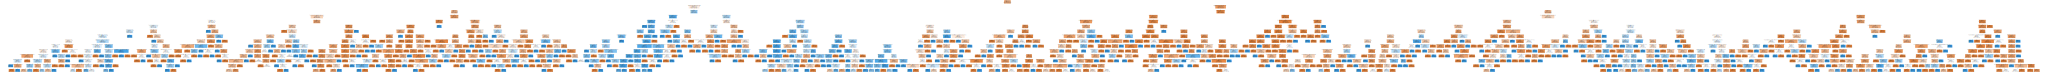

In [25]:
from sklearn import tree
import graphviz
# Export graphviz object from the trained decision tree 
exported = tree.export_graphviz(decision_tree=mytree, 
			# Assign feature names
            out_file=None, feature_names=train_X.columns, 
			# Set precision to 1 and add class names
			precision=1, class_names=['Not churn','Churn'], filled = True)

# Call the Source function and pass the exported graphviz object
graph = graphviz.Source(exported)

# Display the decision tree
display(graph)

In [26]:
# Combine feature names and coefficients into pandas DataFrame
feature_names = pd.DataFrame(train_X.columns, columns=['Feature'])
log_coef = pd.DataFrame(np.transpose(logreg.coef_), columns=['Coefficient'])
coefficients = pd.concat([feature_names, log_coef], axis = 1)

# Calculate exponent of the logistic regression coefficients
coefficients['Exp_Coefficient'] = np.exp(coefficients['Coefficient'])

# Remove coefficients that are equal to zero
coefficients = coefficients[coefficients['Coefficient']!=0]

# Print the values sorted by the exponent coefficient
print(coefficients.sort_values(by=['Exp_Coefficient']))


                           Feature  Coefficient  Exp_Coefficient
4                 PhoneService_Yes    -0.950799         0.386432
22               Contract_Two year    -0.847874         0.428325
27                          tenure    -0.836925         0.433040
16                 TechSupport_Yes    -0.561879         0.570137
21               Contract_One year    -0.522666         0.592937
10              OnlineSecurity_Yes    -0.501148         0.605835
12                OnlineBackup_Yes    -0.208817         0.811544
14            DeviceProtection_Yes    -0.069746         0.932630
3                   Dependents_Yes    -0.043271         0.957652
26      PaymentMethod_Mailed check    -0.028708         0.971700
0                      gender_Male    -0.015403         0.984715
2                      Partner_Yes    -0.009710         0.990337
7      InternetService_Fiber optic     0.004689         1.004700
1                  SeniorCitizen_1     0.043653         1.044620
23            PaperlessBi

# End